In [2]:
import sys

sys.path.insert(0, '/Users/elinaisrayelyan/PycharmProjects/capstone_project')
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import BinaryAUROC
from modules.model.main import ConvCatNet, model_train_loop, model_test_loop
from modules.data.preprocessing import PreProcess

import torch
import tenseal as ts
from modules.encryption.keys import create_ctx


def size_is_ok():
    img = preprocessor.cuda_image_array.copy()[0][0]

    conv1_weight = net.conv1.weight.data.view(

        -1, net.conv1.kernel_size[0],
        net.conv1.kernel_size[1]
    ).tolist()
    conv1_bias = net.conv1.bias.data.tolist()
    nk = img.tolist().copy()[0]

    x_enc_0, windows_nb_0 = ts.im2col_encoding(
        context, nk, 3,
        3, 1
    )
    y = x_enc_0.conv2d_im2col(conv1_weight[0], windows_nb_0) + conv1_bias[0]
    print(y)


def almost_equal(vec1, vec2, m_pow_ten):
    if len(vec1) != len(vec2):
        return False

    upper_bound = pow(10, -m_pow_ten)
    for v1, v2 in zip(vec1, vec2):
        if abs(v1 - v2) > upper_bound:
            return False
    return True

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
image_size = 20  # poly degree /2 should be bigger than image to columns for conv size
# context, server_context = create_ctx(bits_scale=33,poly_mod_degree=32768, num_mul=9)  # scale up as working with floats,
context, server_context = create_ctx(poly_mod_degree=32768, num_mul=8)

In [4]:
preprocessor = PreProcess(image_size=image_size, max_num_images=200)
train_dataloader, test_dataloader = preprocessor.preprocess()

 10%|█         | 200/1920 [01:05<09:24,  3.05it/s]


In [5]:

net = ConvCatNet(image_size=image_size).to(device)
print(net)

ConvCatNet(
  (lrelu): LeakyReLU(negative_slope=0.1)
  (conv1): Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(3, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [6]:
size_is_ok()

In [7]:
EPOCHS = 100
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
bauc = BinaryAUROC(thresholds=None)

In [8]:

# MODEL learns the trivial case of all 1s, which means it has capacity to learn:

for epoch in range(2):  # loop over the dataset multiple times

    model_train_loop(net, train_dataloader, optimizer, criterion, bauc, epoch)
    model_test_loop(net, test_dataloader, criterion, bauc, epoch)


# print('Finished Training')

[1,   100] loss: 57.072, ROC: 0.584, F1_healthy: 0.000

[1,   101] Validation loss: 54.016, ROC: 0.774, F1_healthy: 0.000 

[2,   100] loss: 53.878, ROC: 0.662, F1_healthy: 0.000

[2,   101] Validation loss: 53.391, ROC: 0.771, F1_healthy: 0.000 



# enc

In [16]:
class EncConvNet:

    def __init__(self, torch_nn):
        self.conv1_weight = torch_nn.conv1.weight.data.view(
            -1, torch_nn.conv1.kernel_size[0],
            torch_nn.conv1.kernel_size[1]
        ).tolist()
        self.conv1_bias = torch_nn.conv1.bias.data.tolist()

        self.conv2_weight = torch_nn.conv2.weight.data.view(
            -1, torch_nn.conv2.kernel_size[0],
            torch_nn.conv2.kernel_size[1]
        ).tolist()
        self.conv2_bias = torch_nn.conv2.bias.data.tolist()

        self.fc1_weight = torch_nn.fc1.weight.T.data
        self.fc1_bias = torch_nn.fc1.bias.data.tolist()

        self.fc2_weight = torch_nn.fc2.weight.T.data.tolist()
        self.fc2_bias = torch_nn.fc2.bias.data.tolist()

    def forward(self, enc_x, windows_nb, windows_nb_2=0):
        # conv layer
        enc_channels = 0
        for ind, kernel in enumerate(self.conv1_weight):
            y = enc_x[ind].conv2d_im2col(kernel, windows_nb)

            print("one channel")
            print(y.shape)
            enc_channels += y

        print("the conv shape")
        print(enc_channels.shape)
        enc_channels += self.conv1_bias[0]
        enc_channels_2 = 0
        for ind, kernel in enumerate(self.conv2_weight):
            y = enc_x[ind + 3].conv2d_im2col(kernel, windows_nb_2)
            print("one channel")
            print(y.shape)
            enc_channels_2 += y
        enc_channels_2 += self.conv2_bias[0]

        enc_x_conv_2 = ts.CKKSVector.pack_vectors([enc_channels, enc_channels_2])
        print(enc_x_conv_2.shape)

        # pack all channels into a single flattened vector
        # enc_x = ts.CKKSVector.pack_vectors(enc_channels)
        enc_x = enc_x_conv_2
        print((self.fc1_weight).shape)
        # fc1 layer
        enc_x = enc_x.mm(self.fc1_weight) + self.fc1_bias
        print(enc_x.shape)
        # square activation
        enc_x = EncConvNet.relu(enc_x)
        # fc2 layer
        enc_x = enc_x.mm(self.fc2_weight) + self.fc2_bias
        enc_x = EncConvNet.sigmoid(enc_x)
        return enc_x

    @staticmethod
    def sigmoid(enc_x):
        # We use the polynomial approximation of degree 3
        # sigmoid(x) = 0.5 + 0.197 * x - 0.004 * x^3
        # from https://eprint.iacr.org/2018/462.pdf
        # which fits the function pretty well in the range [-5,5]
        return enc_x.polyval([0.5, 0.197, 0, -0.004])

    @staticmethod
    def relu(enc_x):
        return enc_x.polyval([0.7980839252151725,
                              0.5010412618900529,
                              0.07216459992097435,
                              -4.1650475602117174e-05])

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

In [17]:
enc_net = EncConvNet(net)

In [18]:
real_outputs = []
for idx, data in enumerate(test_dataloader, 0):
    inputs, labels = data
    outputs = net(inputs)
    real_outputs.append(outputs)

In [19]:
img = preprocessor.cuda_image_array[0][0]


In [20]:
real_out = net(img)

In [22]:
enc_outputs = []
for data in test_dataloader:
    img, labels = data
    img = img[0]
    img_1 = torch.nn.functional.pad(img, (1, 1, 1, 1), "constant", 0)
    img_2 = torch.nn.functional.pad(img, (2, 2, 2, 2), "constant", 0)

    kernel_shape = net.conv1.kernel_size

    data_0 = img_1[0]
    data_1 = img_1[1]
    data_2 = img_1[2]

    data_2_0 = img_2[0]
    data_2_1 = img_2[1]
    data_2_2 = img_2[2]
    print(data_1.shape)
    x_enc_0, windows_nb_0 = ts.im2col_encoding(
        context, data_0, kernel_shape[0],
        kernel_shape[1], 1
    )
    x_enc_1, windows_nb_1 = ts.im2col_encoding(
        context, data_1, kernel_shape[0],
        kernel_shape[1], 1
    )
    x_enc_2, windows_nb_2 = ts.im2col_encoding(
        context, data_2, kernel_shape[0],
        kernel_shape[1], 1
    )

    x_enc_1_0, windows_nb_1_0 = ts.im2col_encoding(
        context, data_2_0, 5,
        5, 1
    )
    x_enc_1_1, windows_nb_1_1 = ts.im2col_encoding(
        context, data_2_1, 5,
        5, 1
    )
    x_enc_1_2, windows_nb_1_2 = ts.im2col_encoding(
        context, data_2_2, 5,
        5, 1
    )
    x_enc = (x_enc_0, x_enc_1, x_enc_2, x_enc_1_0, x_enc_1_1, x_enc_1_2)
    enc_output = enc_net(x_enc, windows_nb_1, windows_nb_1_2)
    enc_outputs.append(enc_output.decrypt())

torch.Size([1, 3, 20, 20])
torch.Size([22, 22])
one channel
[400]
one channel
[400]
one channel
[400]
the conv shape
[400]
one channel
[400]
one channel
[400]
one channel
[400]
[800]
torch.Size([800, 128])
[128]
torch.Size([1, 3, 20, 20])
torch.Size([22, 22])
one channel
[400]
one channel
[400]
one channel
[400]
the conv shape
[400]
one channel
[400]
one channel
[400]
one channel
[400]
[800]
torch.Size([800, 128])
[128]
torch.Size([1, 3, 20, 20])
torch.Size([22, 22])
one channel
[400]
one channel
[400]
one channel
[400]
the conv shape
[400]
one channel
[400]
one channel
[400]
one channel
[400]
[800]
torch.Size([800, 128])
[128]
torch.Size([1, 3, 20, 20])
torch.Size([22, 22])
one channel
[400]
one channel
[400]
one channel
[400]
the conv shape
[400]
one channel
[400]
one channel
[400]
one channel
[400]
[800]
torch.Size([800, 128])
[128]
torch.Size([1, 3, 20, 20])
torch.Size([22, 22])
one channel
[400]
one channel
[400]
one channel
[400]
the conv shape
[400]
one channel
[400]
one channel

In [23]:
import numpy as np

np.average(
    np.abs(np.array(enc_outputs) - np.array([torch.flatten(i)[0].detach().numpy() for i in real_outputs])
           )
)


0.10257040538447762

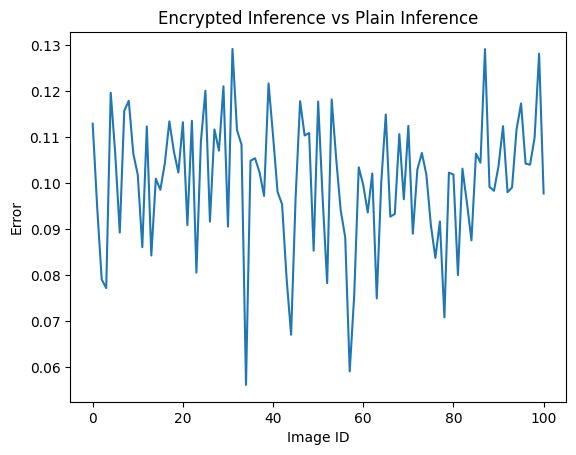

In [26]:
import matplotlib.pyplot as plt

plt.plot(
    np.abs(np.array(sum(enc_outputs, [])) - np.array([torch.flatten(i)[0].detach().numpy() for i in real_outputs]))
)
plt.ylabel("Error")
plt.xlabel("Image ID")
plt.title("Encrypted Inference vs Plain Inference")
plt.savefig("enc_vs_plain_cnn.png", dpi=300)

In [ ]:
# take into account that errors can vary upon each session of running